# Introduction to signal transformation

**Signal transformation** techniques can help to extract meaningful information, reduce noise, or prepare data for further analysis. This notebook covers three examples:
* Fast Fourier Transform (FFT)
* Short Time Fourier Transform (STFT)
* Continuous Wavelet Transform (CWT)
* Discrete Wavelet Transform (DWT)

## Contents:
* [Notebook set-up](#setup)
* [Definitions](#definitions)
    * [Wave](#wave)
    * [Wavelet](#wavelet)
    * [Signal](#signal)
    * [Signal processing](#signal_processing)
* [Fast Fourier Transform (FFT)](#fft)
* [Short Time Fourier Transform (STFT)](#stft)
* [The Wavelet Transform](#wavelet_transform)
* [Discrete Wavelet Transformation (DWT)](#dwt)
* [Continuous Wavelet Transformation (CWT)](#cwt)
* [Exploring a combination of DWT and CWT](#explore)
* [Conclusion](#conclusion)

## Notebook set-up <a class="anchor" id="setup"></a>

In [1]:
# Import packages
from IPython.display import Image
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pywt
from scipy import signal
from scipy.fftpack import fft, ifft

In [2]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Clip to last 90 minutes
    fhr = fhr.tail(90*60)

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    return(fhr)

In [3]:
# Import example of a FHR and UCR to be used in notebook
ctg = pd.read_csv('data_csv/1001.csv')
fhr = clean_fhr(ctg['FHR'])
uc = ctg['UC']

## Definitions <a class="anchor" id="definitions"></a>

### Wave <a class="anchor" id="wave"></a>

A wave is an osciallation about a rest position. You can notice it has a rest point (if drew horizontal line through middle), peaks (high point above rest position) and troughs (low point below rest poition). Its wavelength is the distance covered by one cycle of the wave (peak to peak or trough to trough).

Two further properties of a wave:
* **Amplitude** = distance between the rest position and the peak/trough.
* **Frequency** = number of waves passing a point per second, with frequency unit of hertz (Hz).

Below is an example of a type of wave called a **sine wave**. Sine are basic, continuous repetitative waves representing a single frequency, with no harmonics (distortions).

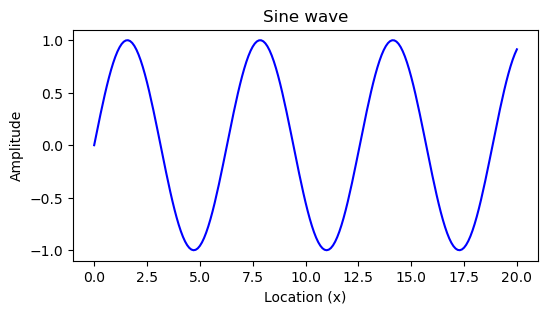

In [4]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.01-The-Basics-of-waves.html

x = np.linspace(0, 20, 201)
y = np.sin(x)

plt.figure(figsize = (6, 3))
plt.plot(x, y, 'b')
plt.ylabel('Amplitude')
plt.xlabel('Location (x)')
plt.title('Sine wave')
plt.show()

### Wavelet <a class="anchor" id="wavelet"></a>

The word wavelet comes from the french *ondelette* which means "little wave". For a function to be a wavelet it must:
* **Have a mean of zero** - This is known as the admissibility condition, or as having no zero-frequency component. Essentially, the average value of your function is 0
* **Be rapidly decaying** - This means it is localised in time and does not extend to infinity (unlike the sine wave above). This is also known as having finite energy.

There are many types of wavelets and they are grouped into **families**. Below is an example of a Morlet wavelet.

The scale of a wavelet refers to the width of the wavelet. It can be defined as the distance between oscillations in the wavelet (e.g. for the Morlet), or it can be some average width of the entire wavelet (e.g. for the Marr or Mexican hat).[[source]](https://paos.colorado.edu/research/wavelets/faq.html)

Scaling is the process of stretching or shrinking the wavelet in time.

When referring to wavelets, we often talk about **scales** rather than **frequencies**. This is because the term "frequency" doesn't technically make sense for wavelets as they are **rapidly decaying**, and so we might instead talk about **pseudo-frequency**. **Scale and frequency are inversely proportional**. To calculate the change in frequency when scaling a wavelet, you can do: pseudo-frequency = centre frequency / scaling factor. For example, 5Hz / 0.5 = 10Hz (higher frequency), or 5Hz / 2 = 2.5Hz (lower frequency). The centre frequency of the wavelet describes its general behaviour, determined by approximating the wavelet to a sine wave and taking its frequency. Another example: if take a wavelet with pseudo-frequency 1 and scale it by 2, the daughter wavelet will have a pseudo-frequency of 0.5.

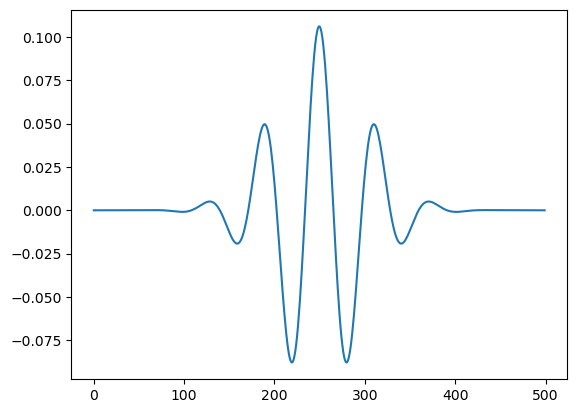

In [5]:
# Define wavelet parameters
M = 500 # Length of wavelet
s = 50 # Width parameter of wavelet
w = 5 # Omega0

# Create and plot wavelet
wavelet = signal.morlet2(M, s, w)
plt.plot(np.real(wavelet))
plt.show()

### Signal <a class="anchor" id="signal"></a>

A signal is a function conveying information about a phenomenon. Any quantity that varies over space or time can be used as a signal. Examples of signals: audio, video, speech, image, sonar, and radar. In this project, the signals we are focussing on are the **fetal heartbeat (FHR)** and **uterine contractions (UC)** recorded during labour using **cardiotocography (CTG)**.

Properties of signals:
* **Amplitude**
* **Frequency**
* **Wavelength**
* **Phase**

These are not always relevant - for example, some signals will not have a well-defined frequency (e.g. random signals), with the concept of frequency being most relevant for signals that exhibit some form of **periodicity** (repetition after a fixed interval) or **oscillation** (variation about a central point). However, in any case, frequencies relevant for the signal can be identified (such as through using Fourier transformation), even if it doesn't feel as intuitive as when you look at a sine wave and see frequency.

You can have a **continuous signal** (where it is continuous - at every step there is a value, no matter how far you zoom in) or a **discrete-time signal** (which is only defined at specific steps. A continuous signal is digitised by sampling it at a specific sample rate. Hence, the **sampling rate/frequency** is the number of samples per second (or other unit) taken from a continuous signal to make a discrete or digital signal - e.g. measured in cycles per second or Hertz (Hz). In this project, **FHR and UC are continuous signals that were sampled at 4Hz**. The CTG recordings were using to calculate FHR and UC in bpm, and the dataset we have provides the **results (e.g. FHR in bpm) for each second of labour**.

### Signal processing <a class="anchor" id="signal_processing"></a>

Signal processing can include dealing with irregular/missing data, noise and outliers, among other things.

There are many signal processing techniques - with one example being transforms like FFT, DWT and CWT. These signal transformations can be considered types of **multiresolution analysis (MRA)**. MRA refers to breaking a signal into components (which would produce the original signal if added back together).

## Signal Transformation Technique #1: The Fast Fourier Transform (FFT) <a class="anchor" id="fft"></a>

FFT is an efficient algorithm for calculating the Discrete Fourier Transform and is the standard way to calculate a fourier transform. FFT can be used to decompose a signal into its **frequency** components. It breaks down a signal into a series of wine waves (each with unique magnitudes, frequencies and phases). Results are displayed in a figure called a **power spectrum**, where the amplitude of the sinusoidal terms are plot against their frequency.

See the example below - we added together a 1Hz, 4Hz and 7Hz sine wave to create a single signal. Applying FFT allows us to identify those frequencies as being present, as in the power spectrum below.

This is **not the best technique** for this project, we are interested in not just what frequencies occurred but when they were present. FFT is more suited to signals with a **stationary frequency spectrum** (i.e. frequencies present are not time-dependent and could be present equally anywhere in the signal), since it represents signals using sine waves which are not localised in time or space.

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


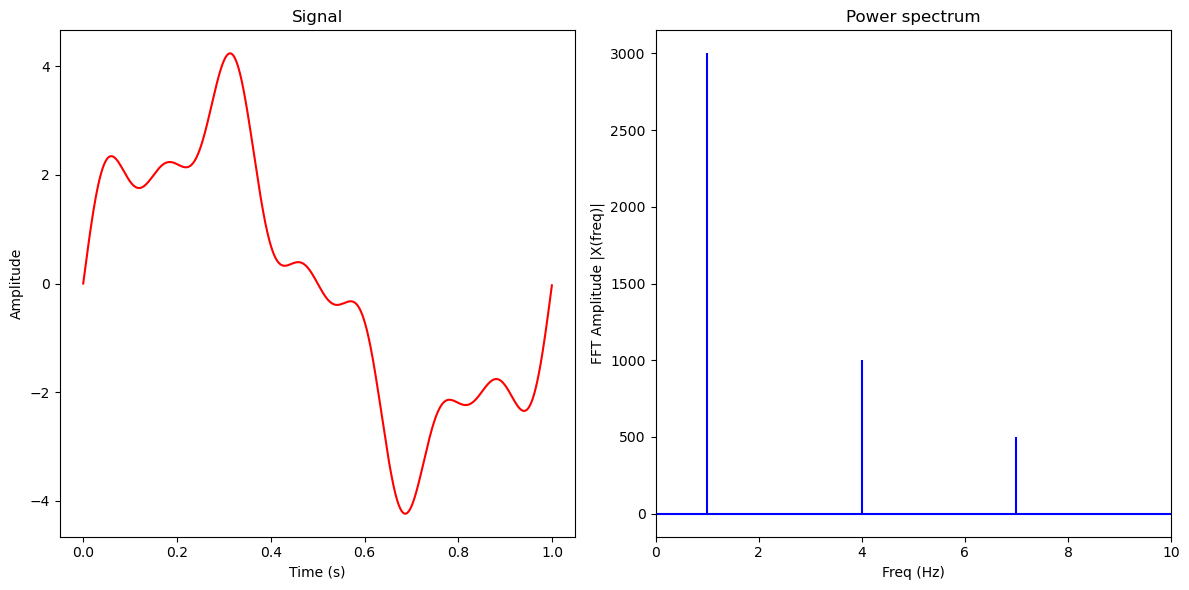

In [6]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html

# Create an example signal containing 3 frequencies - 1, 4 and 7
sampling_rate = 2000
sampling_interval = 1/sampling_rate
t = np.arange(0, 1, sampling_interval)
freq = 1
x = 3*np.sin(2*np.pi*freq*t)
freq = 4
x += np.sin(2*np.pi*freq*t)
freq = 7
x += 0.5* np.sin(2*np.pi*freq*t)

# Apply the Fast Fourier Transform
X = fft(x)

# Plot the transform
plt.figure(figsize = (12, 6))
plt.subplot(122)
N = len(X)
n = np.arange(N)
T = N/sampling_rate
freq = n/T 
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)
plt.title('Power spectrum')

# Plot the signal
plt.subplot(121)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal')

plt.tight_layout()
plt.show()

## Signal Transformation Technique #2: Short Time Fourier Transform (STFT) <a class="anchor" id="stft"></a>

STFT is designed to provide some information about when frequencies occurred, the signal is split into several parts of equal length before the Fourier transform.

For example, if split into 3 parts and identiy frequency in the 2nd, you know it occurred at some point in that time bracket.

A limitation of this method relates to the uncertainty principle - the smaller the window, the more we'll know about when the frequency occurred, but the less we'll know about the frequencies present. Wavelet transform is better for signals with a dynamic frequency spectrum.[[source]](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

### Example

Matplotlib `specgram` to compute and plot spectogram. In the spectogram, the data have been split into NFFT length segments and the spectrum of each section is computed.

Some function inputs:
* `Fs` = The sampling frequency (samples per time unit). It is used to calculate the Fourier frequencies, freqs, in cycles per time unit
* `NFFT` = Number of data points used in each block for FFT - a power of 2 is most efficient
* `window` = You can apply windowing as the sudden cut off of signal makes large burst of energy called transient which ruin spectogram. Windowing will attenuate the beginning and end of each time chunk, and default function is hanning window.
* `mode` = spectrumed used - either `psd` (power spectral density), `magnitude`, `angle` (phase spectrum without unwrapped), `phase` (phase spectrum with unwrapping)

The CTU-CHB PhysioNet page says that FRH and UC were sampled at 4Hz, so I understand that to be the sampling frequency. This means the Nyquist frequency is 2Hz (the highest frequency that equipment of a given sample rate can reliably measure, which is half ot he sample rate) - hence the Y axis limits. 

<mark>If NFFT referring to time axis or frequency axis? Is NFFT the number of frequencies to calculate the spectogram for?</mark>

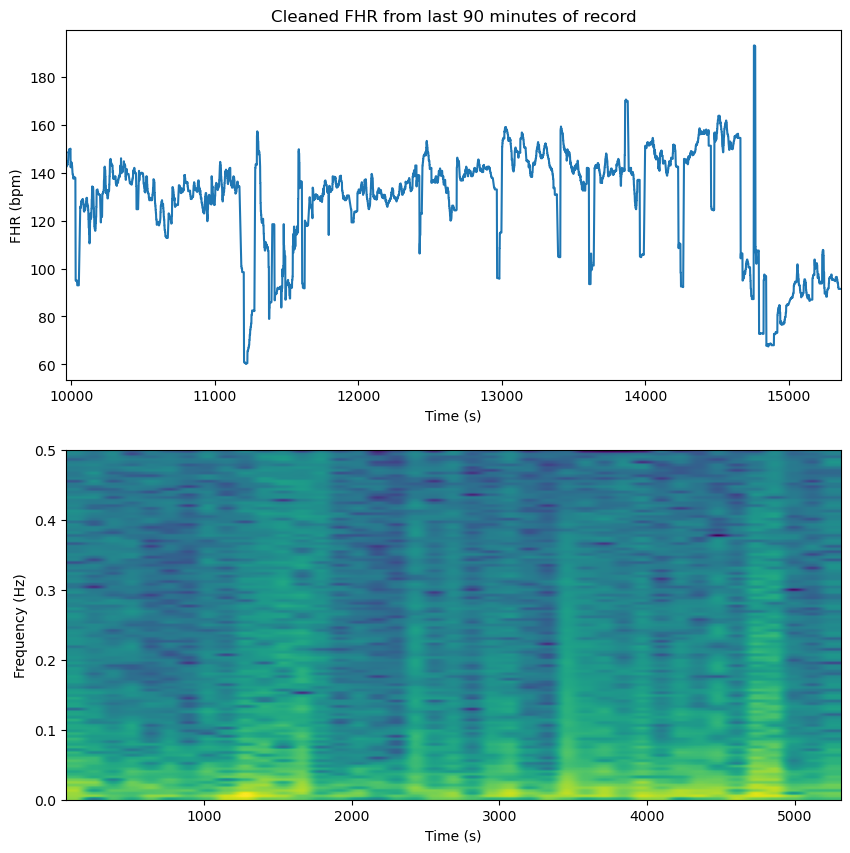

In [7]:
# Plot FHR
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

ax[0].plot(fhr)
ax[0].margins(x=0)
ax[0].set_title('Cleaned FHR from last 90 minutes of record')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('FHR (bpm)')

ax[1].specgram(x=fhr,
               NFFT=256,
               Fs=1,
               detrend='mean',
               window=None,
               noverlap=128,
               mode='psd')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')

plt.show()

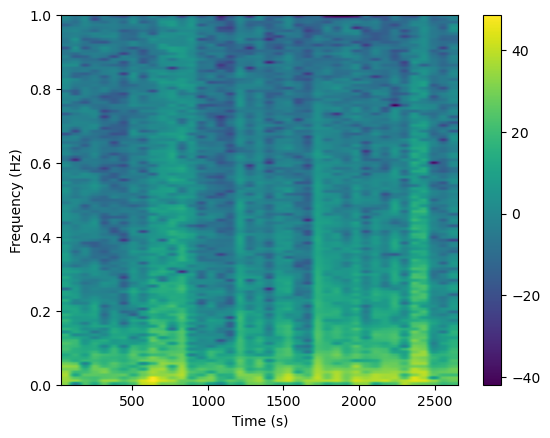

In [8]:
plt.specgram(x=fhr,
             NFFT=256,
             Fs=2,
             detrend='mean',
             window=None,
             noverlap=128,
             mode='psd')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

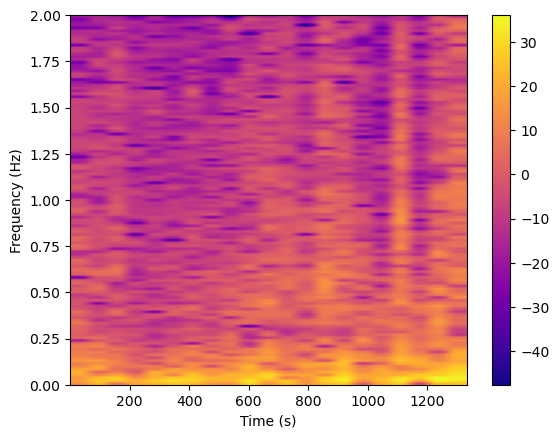

In [9]:
plt.specgram(x=uc.head(90*60),
             NFFT=256, # number of points in each NFFT block
             Fs=4, # sampling frequency
             detrend='linear', # removes mean trend
             window=None, # applying windowing to attenuate start and end of each chunk
             noverlap=2,
             cmap='plasma',
             mode='psd')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## The Wavelet Transform <a class="anchor" id="wavelet_transform"></a>

The wavelet transform decomposes a signal by **frequency** and **time**. This is better than FFT for signals with a **dynamic frequency spectrum** (i.e. frequency spectrum changes over time or changes abruptly for short periods of time).

The general principle of the wavelet transform is to look at the signal on different scales. It uses a series of **wavelet functions which have different scales** (i.e. different frequencies - scale is just the inverse of frequency). There are many different wavelets to choose from. The chosen wavelet is referred to as the **mother wavelet** and the scaled wavelets are **daughter wavelets**. **Lower frequency wavelets** capture slowly varying changes in a signal (i.e. lower frequencies in signal). **Higher frequency wavelets** capture abrupt change sin a signal (i.e. higher frequencies in signal).

The wavelets are **shifted** (meaning they are progressively moved along the length of the signal) and multiplied with the signal at each point. This is also known as **convolving** the signal with the wavelet. The result is the **level of similarity** between the signal and the wavelet ath each point. This is repeated, with the signal convolved with a selection of wavelets each at different scales. If there is good simlarity, you'll get a fairly large value, but if not, the product value will be small or zero. The results calculated from this computation are referred to as **coefficients**.

There are two types of wavelet transform, which work in different ways and produce different outcomes:
* Discrete Wavelet Transform (DWT)
* Continuous Wavelet Transform (CWT)

## Signal Transformation Technique #3 - Discrete Wavelet Transformation (DWT) <a class="anchor" id="dwt"></a>

DWT produces a **time-scale** representation of a signal (rather than a continuous time-frequency representation like a scaleogram). It has applications like **signal compression**, **denoising** and feature extraction.

Types of wavelet that are primarily associated with DWT:
* Haar wavelet
* Daubechies (db) wavelets
* Symlet wavelets
* Biorthogonal wavelets
* Reverse biorthogonal wavelets

This technique is less relevant than CWT for this project, as we are more interested in time-frequency analysis than in denoising the signal.

##### How does it work? [sources [1](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/), [2](https://en.wikipedia.org/wiki/Discrete_wavelet_transform) and [3](https://paos.colorado.edu/research/wavelets/faq.html)]

DWT decomposes a signal by passing it through a series of filters called a **filter-bank** wherein the mother wavelet is **shifted and scaled by powers of 2**.

1. Pass signal through **low-pass filter** producing **approximation coefficients** which represent **low frequency** information in the signal. The low-pass filter is analogous to the **scaling function**, which is a mathematical function using in wavelet transformation that represents a scaling/smoothing operation on the signal. The low-pass filter is like a discrete version of the scaling function in CWT, and helps to provide us with an approximation of the signal at a coarser scale. It's coarser/discrete because, in DWT, the wavelet skips along the time series and only does the wavelet transform when the wavelet no longer overlaps the previous one (which is known as being **orthogonal**) (meanwhile in CWT, the wavelet slides along and each wavelet overlaps the next, hence more computationally expensive/redundant information between transforms).

2. Simultaneously pass signal through **high-pass filter** producing **detail coefficients** which represent **high frequency** information in the signal. The high-pass filter is analogous to the **wavelet function**, a mathematical function presenting a wavelet that is responsible for capturing and characteristising the high-frequency details of a signal in CWT and used to analyse and extract fine-scale details in the signal.

3. Half the frequencies of the signal have now been removed, so **half the samples can be discarded** (according to *Nyquists rule*). The next step is therefore just on the **output of the low-pass filter (approximation coefficients)**.

4. This sub-sample is again passed through a low-pass and high-pass filter, but with the scale increased to **scale factor 2** (hence, looking at behaviour of half the frequency of before). At this level, the time resolution has halved whilst the frequency resolution has doubled

5. This repeats, continuing to have the sample and increasing the scale by a factor of 2 (1, 2, 4, 8, 16...) until the **maximum decomposition level** is reached (i.e. due to the downsampling at each level, we reach a point where the number of samples is smaller than the length of the wavelet filter, which is the maximum decomposition level)

Note: The low-pass and high-pass filters are not wavelets themselves. The high-pass filter determines the wavelet function ()

Below is an illustration of a filter-bank from 3-level DWT. You'll see that we end up with 4 sets of coefficients, as we get two from the last level.

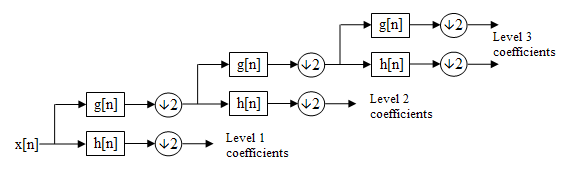

In [10]:
# Source: https://en.wikipedia.org/wiki/Discrete_wavelet_transform#/media/File:Wavelets_-_Filter_Bank.png
Image('images/dwt_filter_bank.png')

##### Why is DWT good for denoising?

It captures the **global structure (low frequency information)** and local details (high frequency information) at different scales, and this is useful for denoising, because **noise tends to have high frequency components** which can be seperated from the true signal during decomposition.

##### Inverse DWT

It it possible to use DWT for analysis (decomposition) and synthesis (reconstruction) of a signal. To reconstruct a signal, you apply inverse DWT, which involves combining the approximation and detail coefficients from all levels to recreate the original signal.

#### Example: FHR and UC

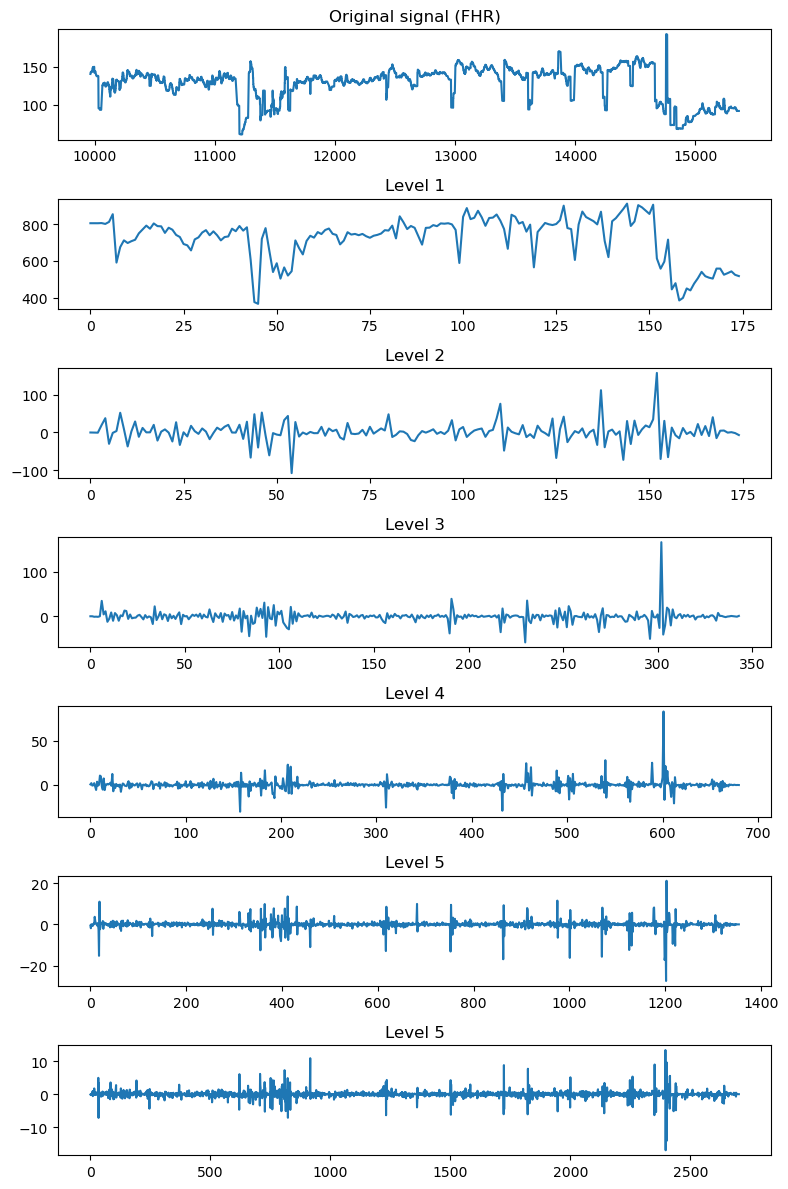

In [11]:
# Decompose fhr using db wavelet down to 5 levels
wavelets = pywt.wavedec(fhr, 'db4', level=5)

# Plot the original signal
fig, ax = plt.subplots(nrows=len(wavelets)+1, figsize=(8, 12))
ax[0].plot(fhr)
ax[0].set_title('Original signal (FHR)')

# Plot the output from DWT
for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)
   ax[i+1].set_title(f'Level {i+1}')
   if i == 5:
      ax[i+1].set_title(f'Level {i}')
plt.tight_layout()

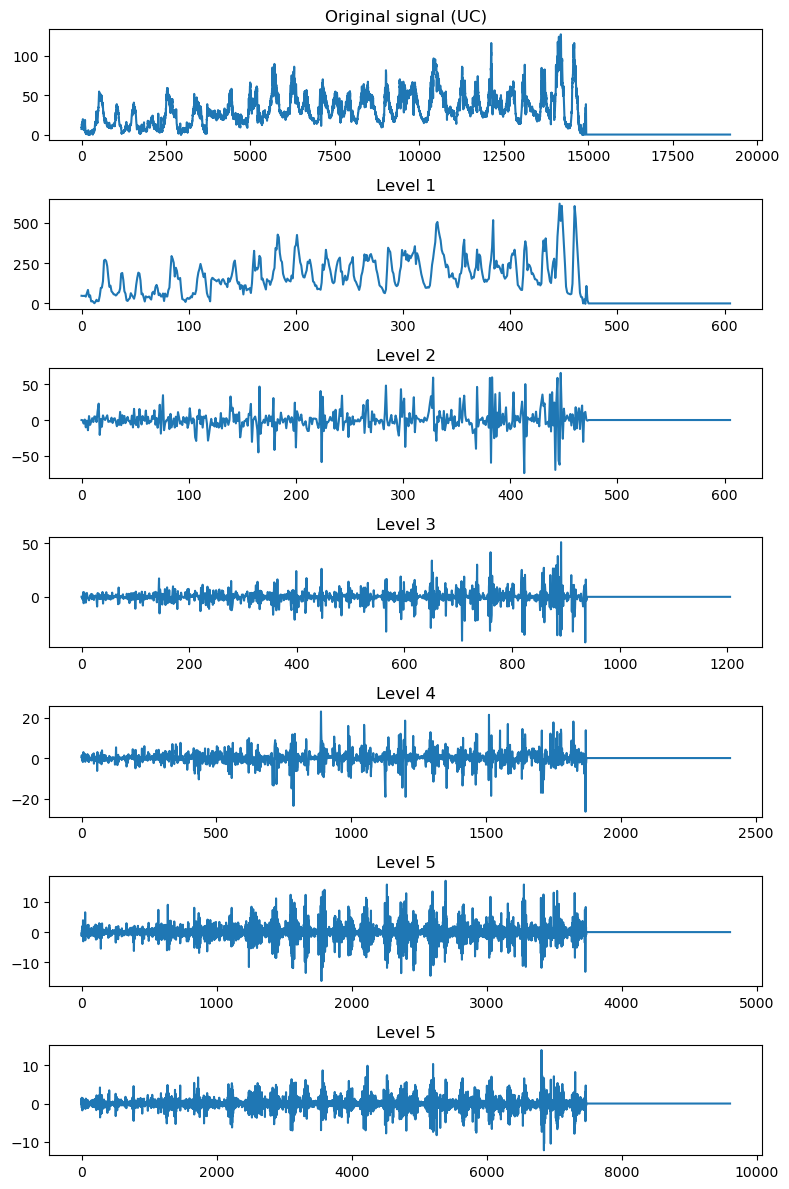

In [12]:
# Decompose uc using db wavelet down to 5 levels
wavelets = pywt.wavedec(uc, 'db4', level=5)

# Plot the original signal
fig, ax = plt.subplots(nrows=len(wavelets)+1, figsize=(8, 12))
ax[0].plot(uc)
ax[0].set_title('Original signal (UC)')

# Plot the output from DWT
for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)
   ax[i+1].set_title(f'Level {i+1}')
   if i == 5:
      ax[i+1].set_title(f'Level {i}')
plt.tight_layout()

## Signal Transformation Technique #4 - Continuous Wavelet Transformation (CWT) <a class="anchor" id="cwt"></a>

CWT produces a **scaleogram**, which is a continuous time-frequency representation of the signal.

Types of wavelet that are primarily associated with CWT:
* Morlet wavelet
* Mexican hat or Ricker wavelet
* Gabor wavelets
* Complex morlet wavelet
* Meyer wavelet

##### How does it work?

A wavelet is **shifted** across the signal (multiplying with the signal at each point to find level of local similarity). This is repeated for wavelets of **different scales**, hence obtaining information on the different frequencies available at different timepoints in the signal.

You can use the results to produce a 2-D colour image called a **scaleogram**. In the example below, the scaleogram is produced from a signal that has mostly high frequency, three section of low frequency, which at their peaks have high frequencies. To interpret the scaleogram:
* **X axis is time**
* **Y axis is the wavelet scale (or here converted to frequency**, which is just the inverse - higher scale = lower frequency)
* **Colours represent amplitude** (meaning we're preserving information about the shape of the signal, which we would glean from frequency and amplitude)

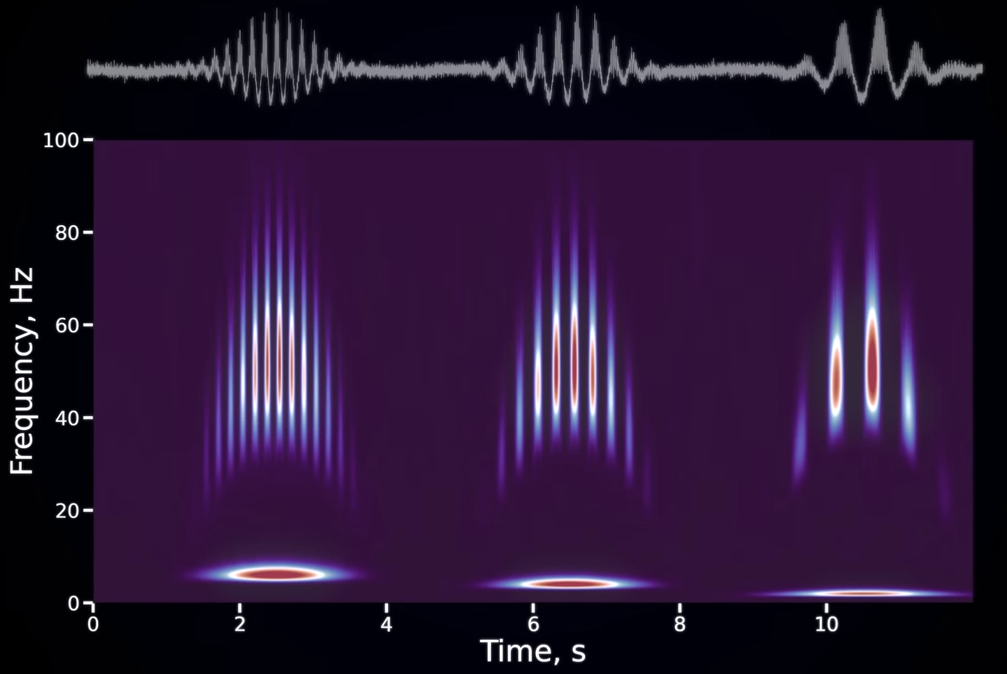

In [13]:
# Source: https://youtu.be/jnxqHcObNK4?si=io1Ae6FLeekiy6ag&t=1826
Image(filename='images/spectogram_example.png') 

##### Uncertainty principle and scaleograms

In signal transformation, we cannot know both frequency and time in perfect detail, which is an example of the uncertainty principle. FFT chooses to focus only on knowing the frequencies present. The wavelet transform makes a trade-off between frequency and time:
* At **lower frequencies**, the uncertainty boxes are wide (i.e. **time less certain**) - which makes sense, as low frequencies by their nature tend to **last longer** (so high time resolution less important)
* At **higher frequencies**, the uncertainty boxes are tall (i.e. **frequency less certain**) - which makes sense, as high frequencies tend to be **brief and localised in time** (so need a higher time resolution).

This can be visuliased using Heisemberg boxes, as in the image below.

This relationship also becomes apparent in **scaleograms**, as the results appear to be relatively blurry, being:
* More stretched in the x axis (time) at lower frequencies (or higher scales)
* More narrow on the x axis (time) at higher frequencies (or lower scales)

This can be observed in the above scaleogram (whith has a frequency axis, rather than scale axis).

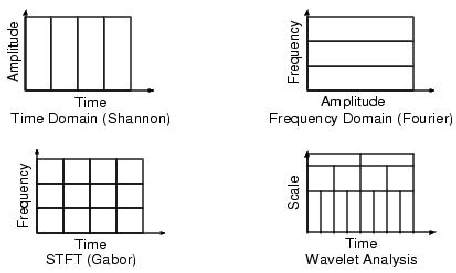

In [14]:
# Source: https://www.researchgate.net/figure/Time-Frequency-STFT-Wavelet-views-of-signal-analysis_fig2_259388604
Image(filename='images/heisenberg_boxes.png') 

##### Example: FHR and UC

(30, 5400)


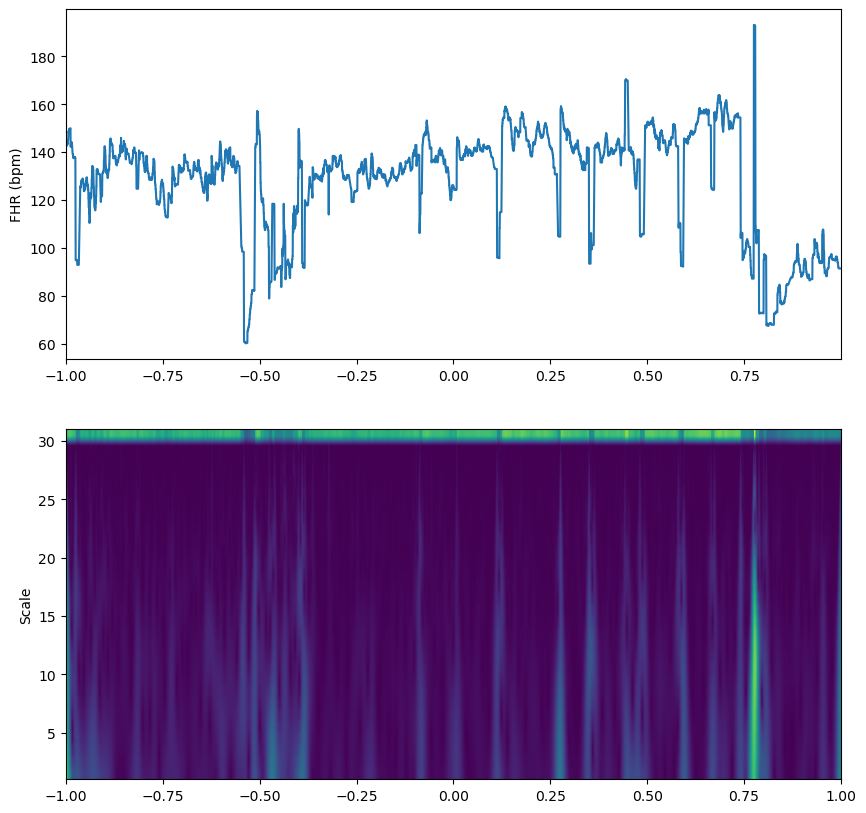

In [15]:
# Plot FHR
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
t = np.linspace(-1, 1, 5400, endpoint=False)
axes[0].plot(t, fhr)
axes[0].margins(x=0)
axes[0].set_ylabel('FHR (bpm)')

# Perform CWT
cwtmatr = signal.cwt(fhr, signal.morlet2, np.arange(1, 31))

# Plot the magnitude
magn = np.absolute(cwtmatr)
print(magn.shape)
axes[1].imshow(
    magn,
    extent=[-1, 1, 1, 31],
    aspect='auto',
)
axes[1].set_ylabel('Scale')
plt.show()

Notice the blurriness and relationship to the uncertainty principle, as above:
* **Top of the graph** = higher scale = **lower frequency** = less certain about time (as last longer) = **wider colours**
* **Lower in graph** = lower scale = **higher frequency** = more certain about time (as more transient) = **narrower colours streching up** as less certain about exact frequency

Also note the bar across the top - I wondered if that's because I hadn't gone to low enough frequencies (i.e. high enough scales). We start CWT at a scale s=1, which will find high frequencies. We then continue for all values of s, smaller or larger than 1 - but, dependeing on your signal, you won't need to do a complete transform, and will use a limited range of scales that adequately captures the frequencies in the signal. We're not computing a truly continuous wavelet transform, as we choose finite numbers, and so this can be referred to as a **discretised version** of CWT (but this is not DWT).

I tried again CWT below but with scales of 1-200 (rather than 1-30 as above), and you can see that the spectogram appears quite different.

(100, 5400)


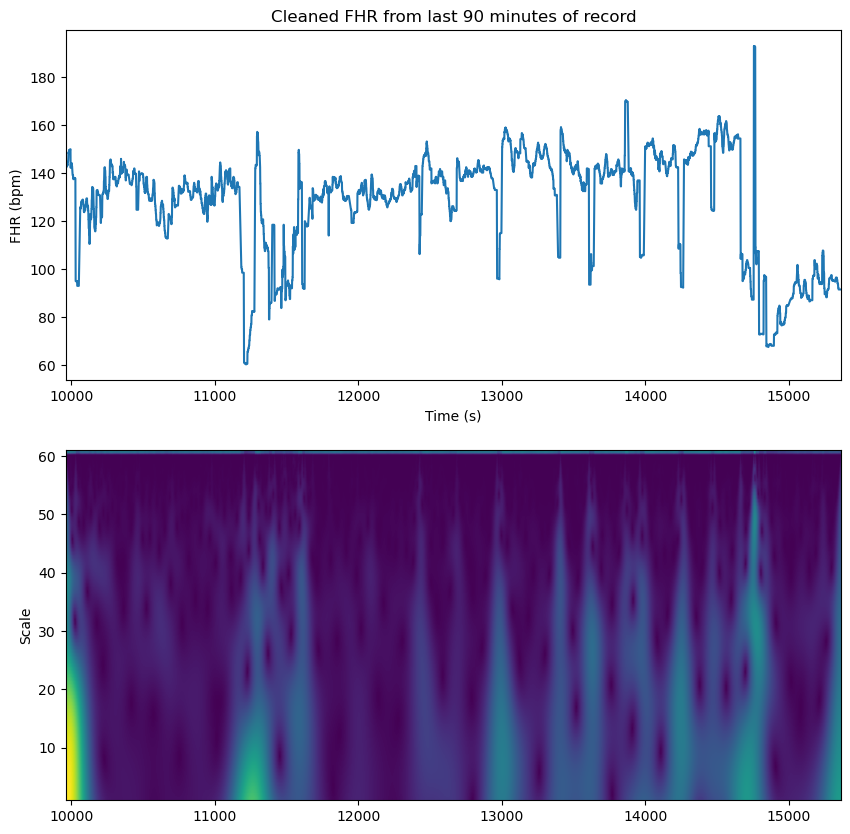

In [16]:
# Plot FHR
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
ax[0].plot(fhr)
ax[0].margins(x=0)
ax[0].set_title('Cleaned FHR from last 90 minutes of record')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('FHR (bpm)')

# Perform CWT
cwtmatr = signal.cwt(fhr, signal.morlet2, np.arange(1, 101))

# Plot the magnitude
magn = np.absolute(cwtmatr)
print(magn.shape)
ax[1].imshow(
    magn,
    extent=[min(fhr.index), max(fhr.index), 1, 61],
    aspect='auto',
)
ax[1].set_ylabel('Scale')
plt.show()

(100, 5400)


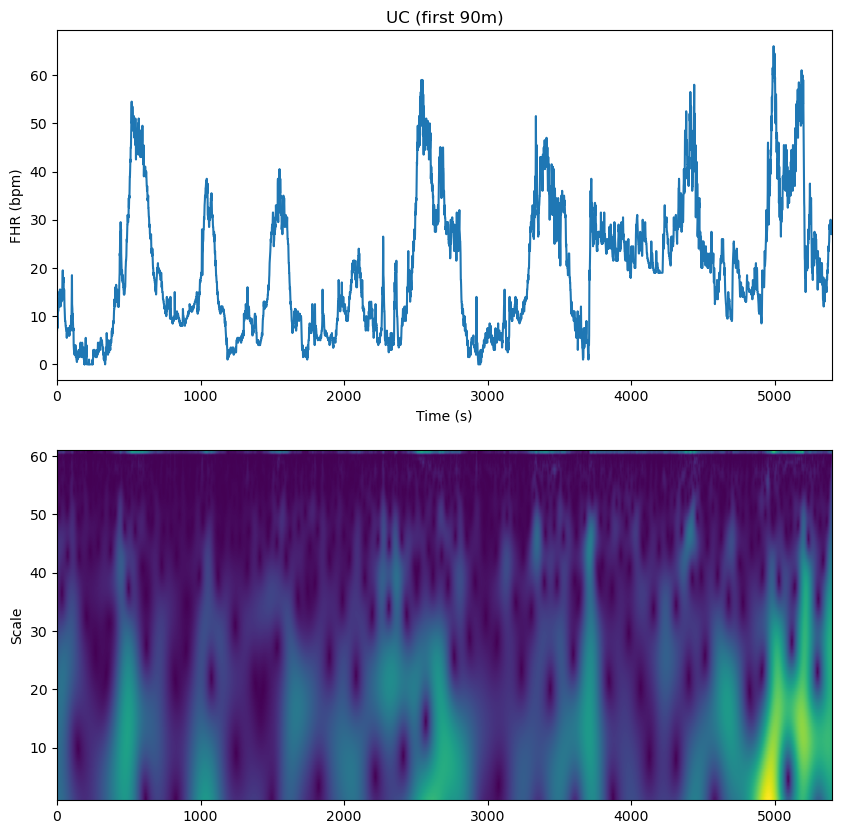

In [17]:
uc_trim = uc.head(90*60)

# Plot UC
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
ax[0].plot(uc_trim)
ax[0].margins(x=0)
ax[0].set_title('UC (first 90m)')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('FHR (bpm)')

# Perform CWT
cwtmatr = signal.cwt(uc_trim, signal.morlet2, np.arange(1, 101))

# Plot the magnitude
magn = np.absolute(cwtmatr)
print(magn.shape)
ax[1].imshow(
    magn,
    extent=[min(uc_trim.index), max(uc_trim.index), 1, 61],
    aspect='auto',
)
ax[1].set_ylabel('Scale')
plt.show()

## Conclusion <a class="anchor" id="conclusion"></a>

This notebook covered four methods for signal transformation/multiresolution analysis - **FFT, STFT, DWT and CWT** - which each have different applications.